✅ Ready to save: simu_mean_rmse_coverage_width_3x3.pdf


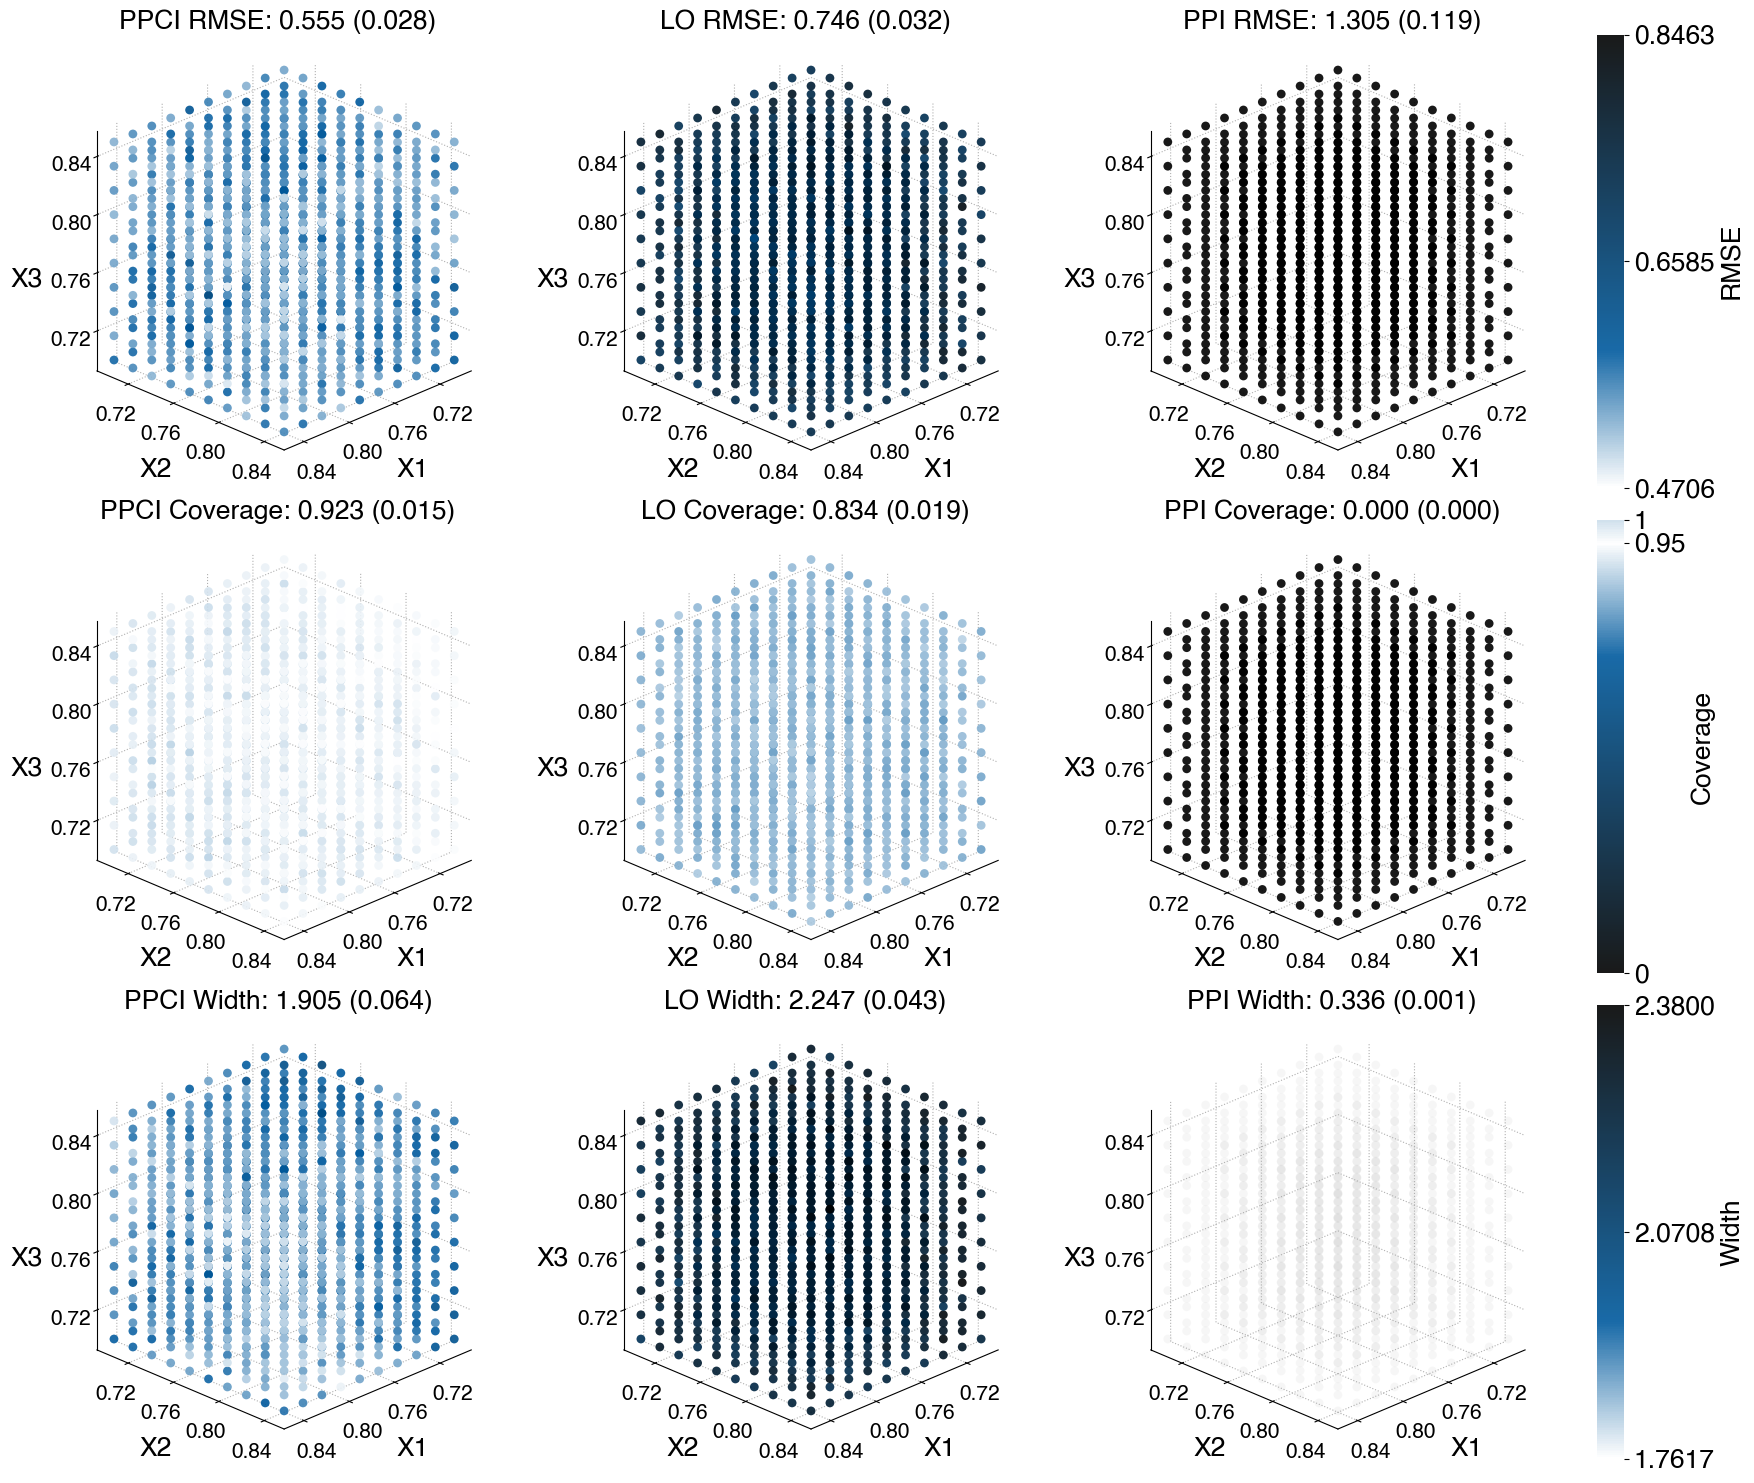

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================
# 0. Font & style
# =============================
FONT_SIZE = 19
font_path = "/home/ysui8/yangsuienv/Helvetica.ttf"

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        mpl.rcParams["font.family"] = prop.get_name()
    except Exception as e:
        print("⚠️ Helvetica load failed; using default font.", e)

mpl.rcParams["font.size"] = FONT_SIZE

# =============================
# 1. Load data
# =============================
csv_path = "./results/simu_ppci_mean_matern52_all_x0.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)

    # x-coordinates
    if all(c in df.columns for c in ["x0_1", "x0_2", "x0_3"]):
        x1 = df["x0_1"].values
        x2 = df["x0_2"].values
        x3 = df["x0_3"].values
    elif all(c in df.columns for c in ["x1", "x2", "x3"]):
        x1 = df["x1"].values
        x2 = df["x2"].values
        x3 = df["x3"].values
    else:
        raise ValueError("Cannot find x-coordinates. Expect (x0_1,x0_2,x0_3) or (x1,x2,x3).")

    # metric columns (flexible for LO name)
    col_cov = {"PPCI": "PPCI_coverage", "LO": "LO_coverage", "PPI": "PPI_coverage"}
    if ("LO_coverage" not in df.columns) and ("PPCI_LO_coverage" in df.columns):
        col_cov["LO"] = "PPCI_LO_coverage"

    col_rmse = {"PPCI": "PPCI_theta_rmse", "LO": "LO_theta_rmse", "PPI": "PPI_theta_rmse"}
    if ("LO_theta_rmse" not in df.columns) and ("PPCI_LO_theta_rmse" in df.columns):
        col_rmse["LO"] = "PPCI_LO_theta_rmse"

    col_wid = {"PPCI": "PPCI_avg_ci_width", "LO": "LO_avg_ci_width", "PPI": "PPI_avg_ci_width"}
    if ("LO_avg_ci_width" not in df.columns) and ("PPCI_LO_avg_ci_width" in df.columns):
        col_wid["LO"] = "PPCI_LO_avg_ci_width"

    # check
    missing = []
    for dct in [col_cov, col_rmse, col_wid]:
        missing += [c for c in dct.values() if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {sorted(set(missing))}")

    coverage = {k: df[v].values.astype(float) for k, v in col_cov.items()}
    rmse = {k: df[v].values.astype(float) for k, v in col_rmse.items()}
    width = {k: df[v].values.astype(float) for k, v in col_wid.items()}

else:
    print("⚠️ Debug mode: generate random data")
    n = 10
    x = np.linspace(0.70, 0.85, n)
    X1, X2, X3 = np.meshgrid(x, x, x)
    x1, x2, x3 = X1.flatten(), X2.flatten(), X3.flatten()

    coverage = {
        "PPCI": np.clip(np.random.normal(0.95, 0.02, size=len(x1)), 0, 1),
        "LO":   np.clip(np.random.normal(0.93, 0.03, size=len(x1)), 0, 1),
        "PPI":  np.clip(np.random.normal(0.75, 0.10, size=len(x1)), 0, 1),
    }
    rmse = {
        "PPCI": np.abs(np.random.normal(0.7, 0.1, size=len(x1))),
        "LO":   np.abs(np.random.normal(0.9, 0.15, size=len(x1))),
        "PPI":  np.abs(np.random.normal(1.4, 0.25, size=len(x1))),
    }
    width = {
        "PPCI": np.abs(np.random.normal(1.8, 0.2, size=len(x1))),
        "LO":   np.abs(np.random.normal(2.6, 0.3, size=len(x1))),
        "PPI":  np.abs(np.random.normal(0.8, 0.15, size=len(x1))),
    }

# axis ranges (auto padding)
def padded_lim(arr, pad_frac=0.05):
    lo, hi = float(np.min(arr)), float(np.max(arr))
    if hi <= lo:
        return [lo - 1e-6, hi + 1e-6]
    pad = pad_frac * (hi - lo)
    return [lo - pad, hi + pad]

xlim = padded_lim(x1, 0.05)
ylim = padded_lim(x2, 0.05)
zlim = padded_lim(x3, 0.05)

# =============================
# 2. Colormaps
# =============================
color_blue = "#005a9e"
color_white = "#ffffff"
color_black = "#000000"

rgb_blue = mcolors.hex2color(color_blue)
rgb_white = mcolors.hex2color(color_white)
rgb_black = mcolors.hex2color(color_black)

saturation_point = 0.30

# (A) Coverage colormap: lightest at 0.95
ratio_sym = 0.05 / (saturation_point - 0.05)
color_at_1 = (
    rgb_white[0] * (1 - ratio_sym) + rgb_blue[0] * ratio_sym,
    rgb_white[1] * (1 - ratio_sym) + rgb_blue[1] * ratio_sym,
    rgb_white[2] * (1 - ratio_sym) + rgb_blue[2] * ratio_sym,
)
coverage_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_coverage_cmap_sym",
    [
        (0.00, rgb_black),
        (1.0 - saturation_point, rgb_blue),  # 0.70
        (0.95, rgb_white),
        (1.00, color_at_1),
    ],
)
coverage_norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

# (B) Sequential colormap for RMSE / Width: small -> light, large -> dark
seq_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_seq_cmap",
    [
        (0.00, rgb_white),
        (saturation_point, rgb_blue),
        (1.00, rgb_black),
    ],
)

# =============================
# 关键修改：RMSE/Width 的 color scale 只用 PPCI & LO 定标
# =============================
scale_methods = ["PPCI", "LO"]  # <-- ignore PPI when setting vmin/vmax to avoid "all black"

rmse_vmin = float(min(np.min(rmse[m]) for m in scale_methods))
rmse_vmax = float(max(np.max(rmse[m]) for m in scale_methods))

width_vmin = float(min(np.min(width[m]) for m in scale_methods))
width_vmax = float(max(np.max(width[m]) for m in scale_methods))

# guard (avoid vmin==vmax)
if rmse_vmax <= rmse_vmin:
    rmse_vmax = rmse_vmin + 1e-12
if width_vmax <= width_vmin:
    width_vmax = width_vmin + 1e-12

# clip=True: values outside [vmin, vmax] are clipped (PPI will become very light if below vmin)
rmse_norm = mcolors.Normalize(vmin=rmse_vmin, vmax=rmse_vmax, clip=True)
width_norm = mcolors.Normalize(vmin=width_vmin, vmax=width_vmax, clip=True)

# =============================
# 3. Plot: 3 rows x 3 cols
#   Row 1: RMSE
#   Row 2: Coverage
#   Row 3: Width
# =============================
fig = plt.figure(figsize=(18, 16), facecolor="white")

method_order = ["PPCI", "LO", "PPI"]
grid_style = {"color": "#B0B0B0", "linestyle": ":", "linewidth": 0.8}

top_margin = 0.95
bottom_margin = 0.06
left_margin = 0.06
right_margin = 0.90
wspace = 0.15
hspace = 0.10

def style_3d(ax):
    ax.set_proj_type("ortho")
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=25, azim=45)

    ax.set_facecolor("white")
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"].update(grid_style)
    ax.yaxis._axinfo["grid"].update(grid_style)
    ax.zaxis._axinfo["grid"].update(grid_style)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    locator = plt.MaxNLocator(nbins=4)
    ax.xaxis.set_major_locator(locator)
    ax.yaxis.set_major_locator(locator)
    ax.zaxis.set_major_locator(locator)

    ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE - 4)

    ax.set_xlabel("X1", fontsize=FONT_SIZE, labelpad=10)
    ax.set_ylabel("X2", fontsize=FONT_SIZE, labelpad=10)
    ax.text2D(
        -0.03, 0.45, "X3",
        transform=ax.transAxes,
        fontsize=FONT_SIZE,
        va="center", ha="right",
    )

gs = fig.add_gridspec(
    nrows=3, ncols=3,
    left=left_margin, right=right_margin,
    top=top_margin, bottom=bottom_margin,
    wspace=wspace, hspace=hspace
)

img_rmse = None
img_cov = None
img_wid = None

PPI_GRAY = "#B0B0B0"  # <-- only for the PPI width panel (gray dots)

for c, method in enumerate(method_order):
    # Row 1: RMSE
    ax1 = fig.add_subplot(gs[0, c], projection="3d")
    style_3d(ax1)
    vals = rmse[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax1.set_title(f"{method} RMSE: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)
    img_rmse = ax1.scatter(
        x1, x2, x3,
        c=vals, cmap=seq_cmap, norm=rmse_norm,
        s=40, edgecolors="black", linewidth=0, alpha=0.9
    )

    # Row 2: Coverage
    ax2 = fig.add_subplot(gs[1, c], projection="3d")
    style_3d(ax2)
    vals = coverage[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax2.set_title(f"{method} Coverage: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)
    img_cov = ax2.scatter(
        x1, x2, x3,
        c=vals, cmap=coverage_cmap, norm=coverage_norm,
        s=40, edgecolors="black", linewidth=0, alpha=0.9
    )

    # Row 3: Width
    ax3 = fig.add_subplot(gs[2, c], projection="3d")
    style_3d(ax3)
    vals = width[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax3.set_title(f"{method} Width: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)

    if method == "PPI":
        # ✅ only change here: PPI width panel uses gray dots (no colormap)
        ax3.scatter(
            x1, x2, x3,
            c=PPI_GRAY,
            s=40, edgecolors="black", linewidth=0, alpha=0.1
        )
        # IMPORTANT: do NOT overwrite img_wid, so the width colorbar
        # stays based on PPCI/LO scale as before.
    else:
        img_wid = ax3.scatter(
            x1, x2, x3,
            c=vals, cmap=seq_cmap, norm=width_norm,
            s=40, edgecolors="black", linewidth=0, alpha=0.9
        )

# =============================
# 4. Three colorbars (one per row)
# =============================
cbar_left = 0.92
cbar_width = 0.015
gap = 0.02
total_h = top_margin - bottom_margin
row_h = (total_h - 2 * gap) / 3.0

# Row 1 (RMSE): start from rmse_vmin (NOT 0)
y0_rmse = top_margin - row_h
cax1 = fig.add_axes([cbar_left, y0_rmse, cbar_width, row_h])
cb1 = fig.colorbar(img_rmse, cax=cax1)
cb1.outline.set_visible(False)
cb1.set_ticks([rmse_vmin, 0.5 * (rmse_vmin + rmse_vmax), rmse_vmax])
cb1.ax.tick_params(labelsize=FONT_SIZE)
cb1.set_label("RMSE", fontsize=FONT_SIZE)

# Row 2 (Coverage): unchanged
y0_cov = top_margin - 2 * row_h - gap
cax2 = fig.add_axes([cbar_left, y0_cov, cbar_width, row_h])
cb2 = fig.colorbar(img_cov, cax=cax2)
cb2.outline.set_visible(False)
cb2.set_ticks([0.0, 0.95, 1.0])
cb2.set_ticklabels(["0", "0.95", "1"])
cb2.ax.tick_params(labelsize=FONT_SIZE)
cb2.set_label("Coverage", fontsize=FONT_SIZE)

# Row 3 (Width): start from width_vmin (NOT 0), and vmin/vmax based on PPCI/LO only
y0_wid = bottom_margin
cax3 = fig.add_axes([cbar_left, y0_wid, cbar_width, row_h])
cb3 = fig.colorbar(img_wid, cax=cax3)
cb3.outline.set_visible(False)
cb3.set_ticks([width_vmin, 0.5 * (width_vmin + width_vmax), width_vmax])
cb3.ax.tick_params(labelsize=FONT_SIZE)
cb3.set_label("Width", fontsize=FONT_SIZE)

# =============================
# 5. Save
# =============================
out_pdf = "simu_mean_rmse_coverage_width_3x3.pdf"
plt.savefig(out_pdf, format="pdf", dpi=400, bbox_inches="tight")
print(f"✅ Ready to save: {out_pdf}")

plt.show()


✅ Ready to save: simu_quantile_rmse_coverage_width_3x3.pdf


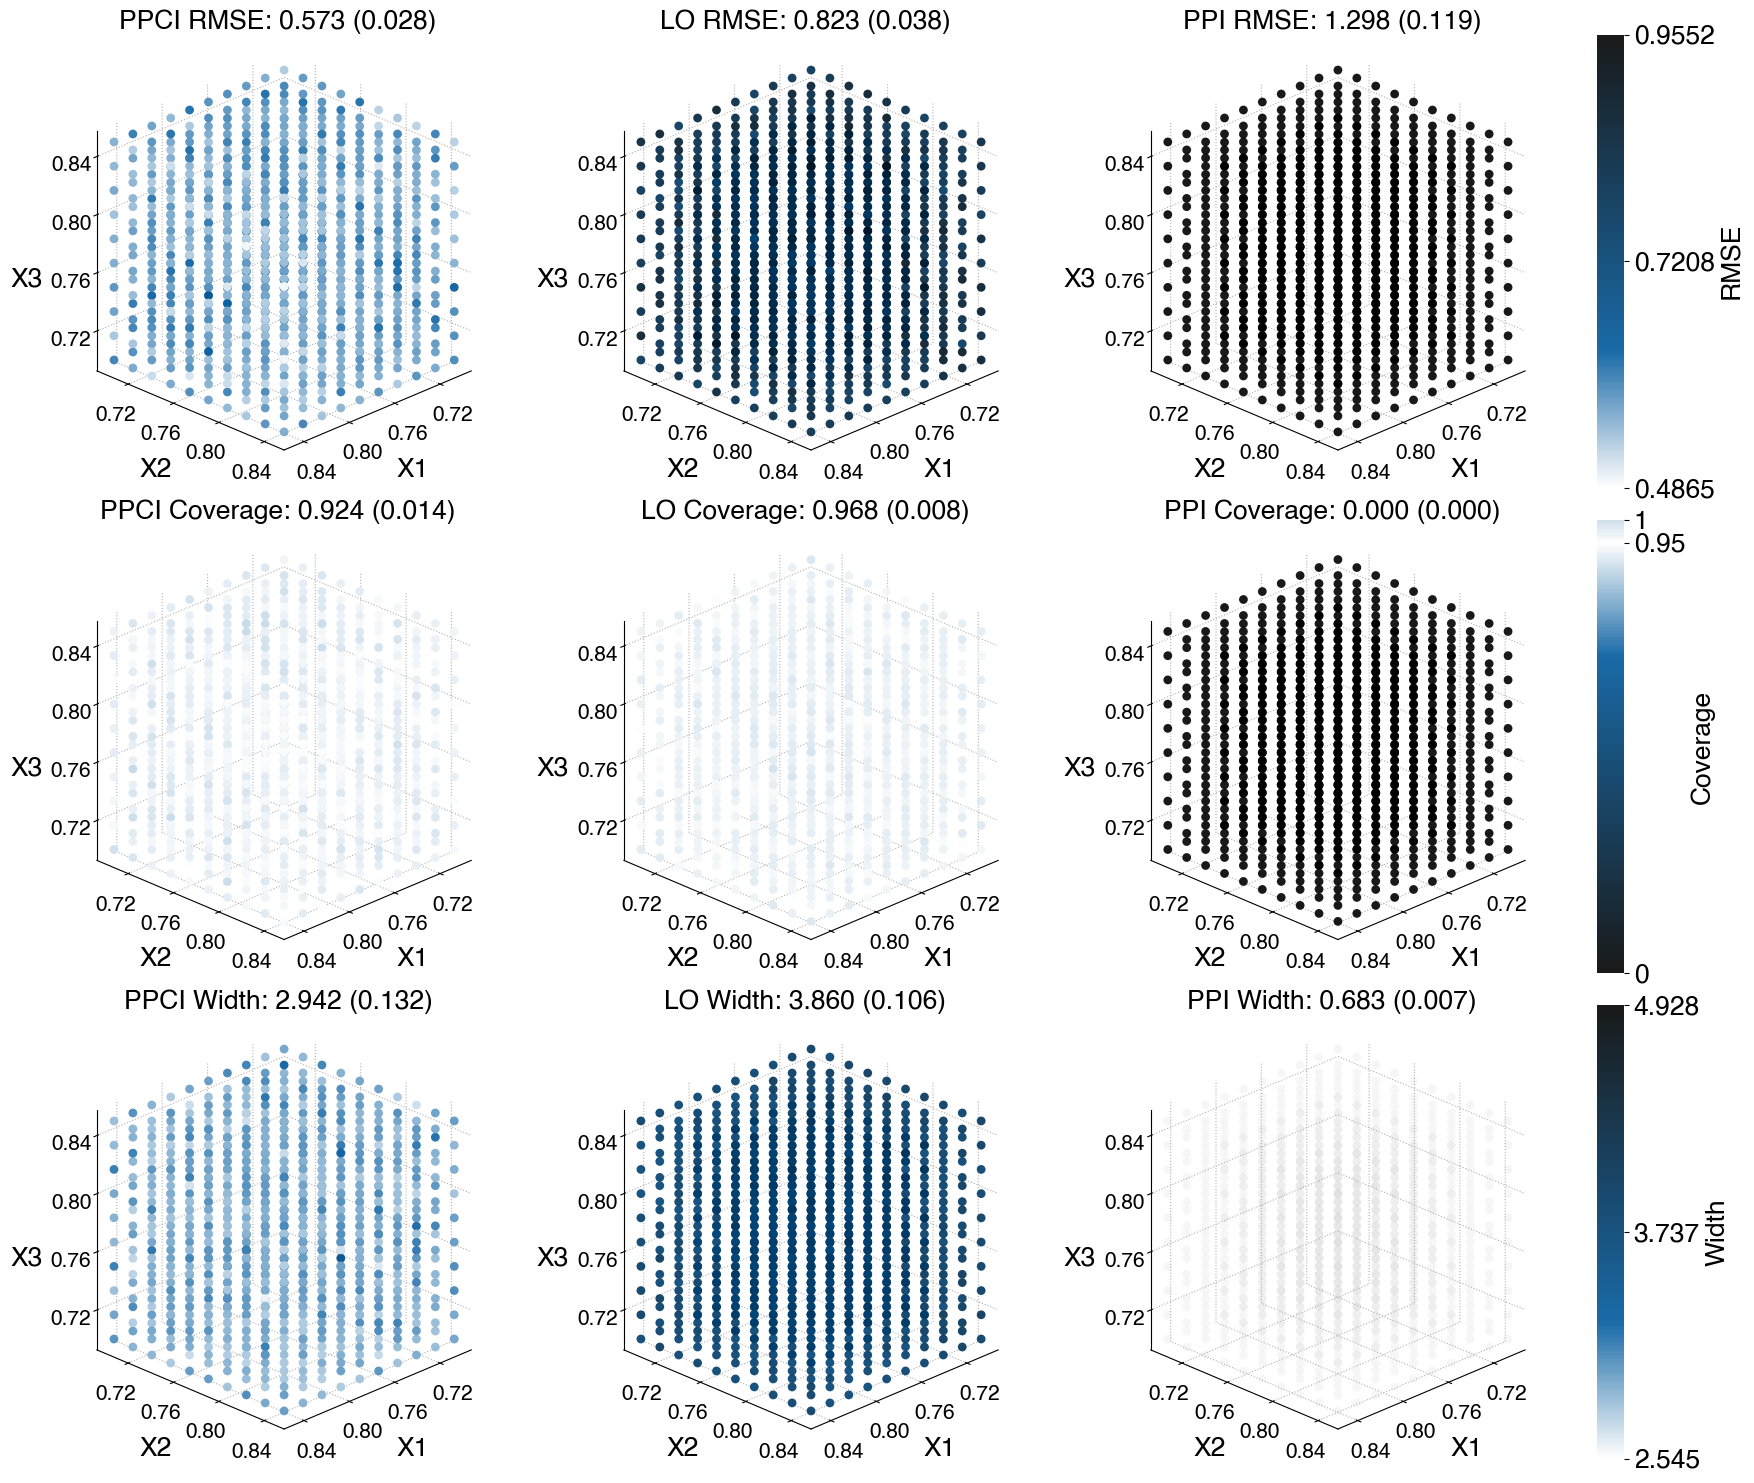

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================
# 0. Font & style
# =============================
FONT_SIZE = 19
font_path = "/home/ysui8/yangsuienv/Helvetica.ttf"

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        mpl.rcParams["font.family"] = prop.get_name()
    except Exception as e:
        print("⚠️ Helvetica load failed; using default font.", e)

mpl.rcParams["font.size"] = FONT_SIZE

# =============================
# 1. Load data
# =============================
csv_path = "./results/simu_ppci_quantile_matern52_all_x0.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)

    # x-coordinates
    if all(c in df.columns for c in ["x0_1", "x0_2", "x0_3"]):
        x1 = df["x0_1"].values
        x2 = df["x0_2"].values
        x3 = df["x0_3"].values
    elif all(c in df.columns for c in ["x1", "x2", "x3"]):
        x1 = df["x1"].values
        x2 = df["x2"].values
        x3 = df["x3"].values
    else:
        raise ValueError("Cannot find x-coordinates. Expect (x0_1,x0_2,x0_3) or (x1,x2,x3).")

    # metric columns (flexible for LO name)
    col_cov = {"PPCI": "PPCI_coverage", "LO": "LO_coverage", "PPI": "PPI_coverage"}
    if ("LO_coverage" not in df.columns) and ("PPCI_LO_coverage" in df.columns):
        col_cov["LO"] = "PPCI_LO_coverage"

    col_rmse = {"PPCI": "PPCI_theta_rmse", "LO": "LO_theta_rmse", "PPI": "PPI_theta_rmse"}
    if ("LO_theta_rmse" not in df.columns) and ("PPCI_LO_theta_rmse" in df.columns):
        col_rmse["LO"] = "PPCI_LO_theta_rmse"

    col_wid = {"PPCI": "PPCI_avg_ci_width", "LO": "LO_avg_ci_width", "PPI": "PPI_avg_ci_width"}
    if ("LO_avg_ci_width" not in df.columns) and ("PPCI_LO_avg_ci_width" in df.columns):
        col_wid["LO"] = "PPCI_LO_avg_ci_width"

    # check
    missing = []
    for dct in [col_cov, col_rmse, col_wid]:
        missing += [c for c in dct.values() if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {sorted(set(missing))}")

    coverage = {k: df[v].values.astype(float) for k, v in col_cov.items()}
    rmse = {k: df[v].values.astype(float) for k, v in col_rmse.items()}
    width = {k: df[v].values.astype(float) for k, v in col_wid.items()}

else:
    print("⚠️ Debug mode: generate random data")
    n = 10
    x = np.linspace(0.70, 0.85, n)
    X1, X2, X3 = np.meshgrid(x, x, x)
    x1, x2, x3 = X1.flatten(), X2.flatten(), X3.flatten()

    coverage = {
        "PPCI": np.clip(np.random.normal(0.95, 0.02, size=len(x1)), 0, 1),
        "LO":   np.clip(np.random.normal(0.93, 0.03, size=len(x1)), 0, 1),
        "PPI":  np.clip(np.random.normal(0.75, 0.10, size=len(x1)), 0, 1),
    }
    rmse = {
        "PPCI": np.abs(np.random.normal(0.7, 0.1, size=len(x1))),
        "LO":   np.abs(np.random.normal(0.9, 0.15, size=len(x1))),
        "PPI":  np.abs(np.random.normal(1.4, 0.25, size=len(x1))),
    }
    width = {
        "PPCI": np.abs(np.random.normal(1.8, 0.2, size=len(x1))),
        "LO":   np.abs(np.random.normal(2.6, 0.3, size=len(x1))),
        "PPI":  np.abs(np.random.normal(0.8, 0.15, size=len(x1))),
    }

# axis ranges (auto padding)
def padded_lim(arr, pad_frac=0.05):
    lo, hi = float(np.min(arr)), float(np.max(arr))
    if hi <= lo:
        return [lo - 1e-6, hi + 1e-6]
    pad = pad_frac * (hi - lo)
    return [lo - pad, hi + pad]

xlim = padded_lim(x1, 0.05)
ylim = padded_lim(x2, 0.05)
zlim = padded_lim(x3, 0.05)

# =============================
# 2. Colormaps
# =============================
color_blue = "#005a9e"
color_white = "#ffffff"
color_black = "#000000"

rgb_blue = mcolors.hex2color(color_blue)
rgb_white = mcolors.hex2color(color_white)
rgb_black = mcolors.hex2color(color_black)

saturation_point = 0.30

# (A) Coverage colormap: lightest at 0.95
ratio_sym = 0.05 / (saturation_point - 0.05)
color_at_1 = (
    rgb_white[0] * (1 - ratio_sym) + rgb_blue[0] * ratio_sym,
    rgb_white[1] * (1 - ratio_sym) + rgb_blue[1] * ratio_sym,
    rgb_white[2] * (1 - ratio_sym) + rgb_blue[2] * ratio_sym,
)
coverage_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_coverage_cmap_sym",
    [
        (0.00, rgb_black),
        (1.0 - saturation_point, rgb_blue),  # 0.70
        (0.95, rgb_white),
        (1.00, color_at_1),
    ],
)
coverage_norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

# (B) Sequential colormap for RMSE / Width: small -> light, large -> dark
seq_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_seq_cmap",
    [
        (0.00, rgb_white),
        (saturation_point, rgb_blue),
        (1.00, rgb_black),
    ],
)

# =============================
# 关键修改：RMSE/Width 的 color scale 只用 PPCI & LO 定标
# =============================
scale_methods = ["PPCI", "LO"]  # <-- ignore PPI when setting vmin/vmax to avoid "all black"

rmse_vmin = float(min(np.min(rmse[m]) for m in scale_methods))
rmse_vmax = float(max(np.max(rmse[m]) for m in scale_methods))

width_vmin = float(min(np.min(width[m]) for m in scale_methods))
width_vmax = float(max(np.max(width[m]) for m in scale_methods))

# guard (avoid vmin==vmax)
if rmse_vmax <= rmse_vmin:
    rmse_vmax = rmse_vmin + 1e-12
if width_vmax <= width_vmin:
    width_vmax = width_vmin + 1e-12

# clip=True: values outside [vmin, vmax] are clipped (PPI will become very light if below vmin)
rmse_norm = mcolors.Normalize(vmin=rmse_vmin, vmax=rmse_vmax, clip=True)
width_norm = mcolors.Normalize(vmin=width_vmin, vmax=width_vmax, clip=True)

# =============================
# 3. Plot: 3 rows x 3 cols
#   Row 1: RMSE
#   Row 2: Coverage
#   Row 3: Width
# =============================
fig = plt.figure(figsize=(18, 16), facecolor="white")

method_order = ["PPCI", "LO", "PPI"]
grid_style = {"color": "#B0B0B0", "linestyle": ":", "linewidth": 0.8}

top_margin = 0.95
bottom_margin = 0.06
left_margin = 0.06
right_margin = 0.90
wspace = 0.15
hspace = 0.10

def style_3d(ax):
    ax.set_proj_type("ortho")
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=25, azim=45)

    ax.set_facecolor("white")
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"].update(grid_style)
    ax.yaxis._axinfo["grid"].update(grid_style)
    ax.zaxis._axinfo["grid"].update(grid_style)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    locator = plt.MaxNLocator(nbins=4)
    ax.xaxis.set_major_locator(locator)
    ax.yaxis.set_major_locator(locator)
    ax.zaxis.set_major_locator(locator)

    ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE - 4)

    ax.set_xlabel("X1", fontsize=FONT_SIZE, labelpad=10)
    ax.set_ylabel("X2", fontsize=FONT_SIZE, labelpad=10)
    ax.text2D(
        -0.03, 0.45, "X3",
        transform=ax.transAxes,
        fontsize=FONT_SIZE,
        va="center", ha="right",
    )

gs = fig.add_gridspec(
    nrows=3, ncols=3,
    left=left_margin, right=right_margin,
    top=top_margin, bottom=bottom_margin,
    wspace=wspace, hspace=hspace
)

img_rmse = None
img_cov = None
img_wid = None

PPI_GRAY = "#B0B0B0"  # <-- only for the PPI width panel (gray dots)

for c, method in enumerate(method_order):
    # Row 1: RMSE
    ax1 = fig.add_subplot(gs[0, c], projection="3d")
    style_3d(ax1)
    vals = rmse[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax1.set_title(f"{method} RMSE: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)
    img_rmse = ax1.scatter(
        x1, x2, x3,
        c=vals, cmap=seq_cmap, norm=rmse_norm,
        s=40, edgecolors="black", linewidth=0, alpha=0.9
    )

    # Row 2: Coverage
    ax2 = fig.add_subplot(gs[1, c], projection="3d")
    style_3d(ax2)
    vals = coverage[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax2.set_title(f"{method} Coverage: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)
    img_cov = ax2.scatter(
        x1, x2, x3,
        c=vals, cmap=coverage_cmap, norm=coverage_norm,
        s=40, edgecolors="black", linewidth=0, alpha=0.9
    )

    # Row 3: Width
    ax3 = fig.add_subplot(gs[2, c], projection="3d")
    style_3d(ax3)
    vals = width[method]
    mu, sd = float(np.mean(vals)), float(np.std(vals))
    ax3.set_title(f"{method} Width: {mu:.3f} ({sd:.3f})", fontsize=FONT_SIZE, pad=-10)

    if method == "PPI":
        # ✅ only change here: PPI width panel uses gray dots (no colormap)
        ax3.scatter(
            x1, x2, x3,
            c=PPI_GRAY,
            s=40, edgecolors="black", linewidth=0, alpha=0.1
        )
        # IMPORTANT: do NOT overwrite img_wid, so the width colorbar
        # stays based on PPCI/LO scale as before.
    else:
        img_wid = ax3.scatter(
            x1, x2, x3,
            c=vals, cmap=seq_cmap, norm=width_norm,
            s=40, edgecolors="black", linewidth=0, alpha=0.9
        )

# =============================
# 4. Three colorbars (one per row)
# =============================
cbar_left = 0.92
cbar_width = 0.015
gap = 0.02
total_h = top_margin - bottom_margin
row_h = (total_h - 2 * gap) / 3.0

# Row 1 (RMSE): start from rmse_vmin (NOT 0)
y0_rmse = top_margin - row_h
cax1 = fig.add_axes([cbar_left, y0_rmse, cbar_width, row_h])
cb1 = fig.colorbar(img_rmse, cax=cax1)
cb1.outline.set_visible(False)
cb1.set_ticks([rmse_vmin, 0.5 * (rmse_vmin + rmse_vmax), rmse_vmax])
cb1.ax.tick_params(labelsize=FONT_SIZE)
cb1.set_label("RMSE", fontsize=FONT_SIZE)

# Row 2 (Coverage): unchanged
y0_cov = top_margin - 2 * row_h - gap
cax2 = fig.add_axes([cbar_left, y0_cov, cbar_width, row_h])
cb2 = fig.colorbar(img_cov, cax=cax2)
cb2.outline.set_visible(False)
cb2.set_ticks([0.0, 0.95, 1.0])
cb2.set_ticklabels(["0", "0.95", "1"])
cb2.ax.tick_params(labelsize=FONT_SIZE)
cb2.set_label("Coverage", fontsize=FONT_SIZE)

# Row 3 (Width): start from width_vmin (NOT 0), and vmin/vmax based on PPCI/LO only
y0_wid = bottom_margin
cax3 = fig.add_axes([cbar_left, y0_wid, cbar_width, row_h])
cb3 = fig.colorbar(img_wid, cax=cax3)
cb3.outline.set_visible(False)
cb3.set_ticks([width_vmin, 0.5 * (width_vmin + width_vmax), width_vmax])
cb3.ax.tick_params(labelsize=FONT_SIZE)
cb3.set_label("Width", fontsize=FONT_SIZE)

# =============================
# 5. Save
# =============================
out_pdf = "simu_quantile_rmse_coverage_width_3x3.pdf"
plt.savefig(out_pdf, format="pdf", dpi=400, bbox_inches="tight")
print(f"✅ Ready to save: {out_pdf}")

plt.show()
